In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('datasets/train.csv')
print(df.head())

   stock_id  date_id  seconds_in_bucket  imbalance_size   
0         0        0                  0      3180602.69  \
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price   
0                        1         0.999812   13380276.64        NaN  \
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  bid_size  ask_price   ask_size  wap    target   
0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704  \
1         NaN   0.999896   3233.04   1.000660   20605.09  1.0 

In [42]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 18 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   stock_id                 int64         
 1   date_id                  int64         
 2   seconds_in_bucket        int64         
 3   imbalance_size           float64       
 4   imbalance_buy_sell_flag  int64         
 5   reference_price          float64       
 6   matched_size             float64       
 7   far_price                float64       
 8   near_price               float64       
 9   bid_price                float64       
 10  bid_size                 float64       
 11  ask_price                float64       
 12  ask_size                 float64       
 13  wap                      float64       
 14  target                   float64       
 15  time_id                  int64         
 16  row_id                   object        
 17  date_id_time             da

In [4]:
print(df['stock_id'].value_counts())

stock_id
0      26455
137    26455
127    26455
128    26455
129    26455
       ...  
153    22605
199    21615
79     16500
135    15950
102    10230
Name: count, Length: 200, dtype: int64


In [47]:
# Fix given stock_id

unique_stocks = df['stock_id'].unique()

first_stock_id = unique_stocks[0]
second_stock_id = unique_stocks[1]
# Filter the DataFrame to only include rows with the first stock_id

df_first_stock = df[df['stock_id'] == first_stock_id]
df_second_stock = df[df['stock_id'] == second_stock_id]

print(f"First stock_id: {first_stock_id}")
print(f"Second stock_id: {second_stock_id}")
print(f"First stock_id size: {df_first_stock.shape}")
print(f"Second stock_id size: {df_second_stock.shape}")

First stock_id: 0
Second stock_id: 1
First stock_id size: (26455, 18)
Second stock_id size: (26455, 18)


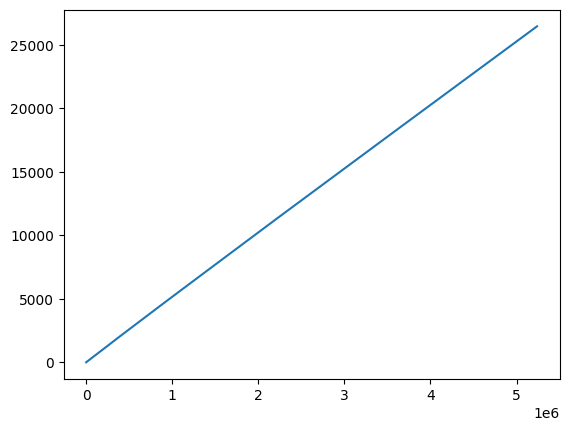

In [49]:
# time_id is the number of the day
# seconds in bucket is the time in seconds since the start of the bucket

plt.plot(df_first_stock['time_id'])

In [31]:
df_first_stock.isna().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  14517
near_price                 14430
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
target                         0
time_id                        0
row_id                         0
date_id_time                   0
dtype: int64

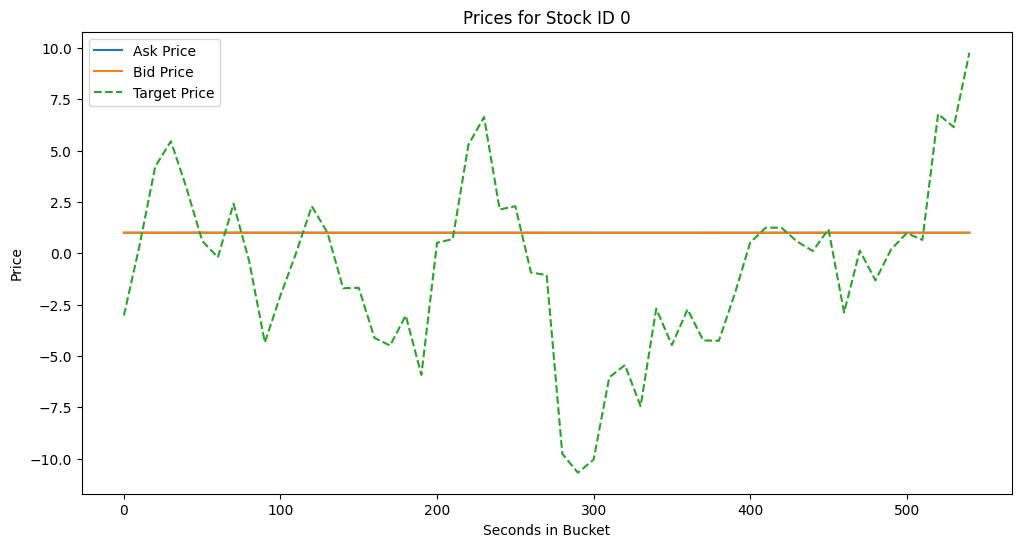

In [ ]:
# plot the ask_price and bid_price in the first day
def plot_prices(df, stock_id, day=0):
    df_stock = df[(df['stock_id'] == stock_id) & (df['date_id'] == day)]

    plt.figure(figsize=(12, 6))

    plt.plot(df_stock['seconds_in_bucket'], df_stock['ask_price'], label='Ask Price')
    plt.plot(df_stock['seconds_in_bucket'], df_stock['bid_price'], label='Bid Price')
    # plt.plot(df_stock['seconds_in_bucket'], df_stock['target'], label='Target Price', linestyle='--')
    plt.title(f'Prices for Stock ID {stock_id}')
    plt.xlabel('Seconds in Bucket')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_prices(df, first_stock_id, day=0)

In [59]:
first_stock_diff = df_first_stock['ask_price'].diff().fillna(0)
second_stock_diff = df_second_stock['ask_price'].diff().fillna(0)

np.corrcoef(first_stock_diff, second_stock_diff)

array([[1.        , 0.29308592],
       [0.29308592, 1.        ]])

In [69]:
# first price everyday
def compute_daily_return(df, stock_id):
    df_stock = df[df['stock_id'] == stock_id]
    stock_first_price = df_stock.groupby('date_id')['ask_price'].first()
    stock_last_price = df_stock.groupby('date_id')['ask_price'].last()
    stock_daily_return = (stock_last_price - stock_first_price) / stock_first_price
    return stock_daily_return


first_stock_daily_return = compute_daily_return(df, first_stock_id)
second_stock_daily_return = compute_daily_return(df, second_stock_id)

print(first_stock_daily_return.head())
print(second_stock_daily_return.head())

np.corrcoef(first_stock_daily_return, second_stock_daily_return)

date_id
0   -0.000643
1   -0.001181
2   -0.001411
3   -0.001952
4   -0.000103
Name: ask_price, dtype: float64
date_id
0    0.000588
1    0.001971
2   -0.002954
3    0.002559
4    0.001132
Name: ask_price, dtype: float64


array([[1.        , 0.39578254],
       [0.39578254, 1.        ]])